In [1]:
import io
import os

from collections import defaultdict
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, MaxPool2D, Reshape
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.utils import get_custom_objects
from keras.layers import Activation

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))

NETWORK_W          = 608
NETWORK_H          = 608

# ------------------------------------------------------------
# needs to be defined as activation class otherwise error
# AttributeError: 'Activation' object has no attribute '__name__'    
class Mish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'


def mysoftplus(x):

    mask_min = tf.cast((x<-20.0),tf.float32)
    ymin = mask_min*tf.math.exp(x)

    mask_max = tf.cast((x>20.0),tf.float32)
    ymax = mask_max*x
    
    mask= tf.cast((abs(x)<=20.0),tf.float32)
    y = mask*tf.math.log(tf.math.exp(x) + 1.0)
    
    return(ymin+ymax+y)    
        


def mish(x):
    return (x* tf.math.tanh(mysoftplus(x)))
    
   
    

get_custom_objects().update({'mish': Mish(mish)})

def _conv_block(inp, convs, skip=False):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)), name='zerop_' + str(conv['layer_idx']))(x)  # peculiar padding as darknet prefer left and top
        
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='convn_' + str(conv['layer_idx']) if conv['bnorm'] else 'conv_' + str(conv['layer_idx']),
                   activation='mish' if conv['activ'] == 2 else None,
                   use_bias=True)(x)
                  
        if conv['activ'] == 1: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
            
    return add([skip_connection, x],  name='add_' + str(conv['layer_idx']+1)) if skip else x

def make_yolov4_model():
  
    input_image = Input(shape=(NETWORK_H, NETWORK_W, 3), name='input_0')

    # Layer  0
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 0}])
    layer_0 = x
    # Layer  1
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 1}])
    layer_1 = x
    
    # Layer  2 
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 2}])
    layer_2 = x
    
    # route  1 (layers = -2)
    x = layer_1
    # Layer  3 => 5
    x = _conv_block(x, [{'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 4},
                        {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 5},
                        {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 6}],
                   skip = True)

    # Layer  8 => 8
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 8}])
    layer_8 = x
    
    # route  8+2 (layers = -1, -7)
    x = concatenate([layer_8, layer_2], name='concat_9')
    
    # Layer 10 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 10},
                        {'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 11}])
    layer_11 = x
    
    # Layer  12
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 12}])
    layer_12 = x
    
    # route  11 (layers = -2)
    x = layer_11
    # Layer 14 => 16
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 14},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 15},
                        {'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 16}],
                   skip = True)
    
    # Layer 18 => 19
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 18},
                        {'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 19}],
                   skip = True)
    
    # Layer  21
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 21}]) 
    layer_21 = x
    
    # route  21+12 (layers = -1,-10)
    x = concatenate([layer_21, layer_12], name='concat_22')
    
    # Layer 23 => 24
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 23},
                        {'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 24}])
    layer_24 = x
    
    # Layer  25
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 25}])
    layer_25 = x
    
    # route  24 (layers = -2)
    x = layer_24
    
    # Layer 27 => 29
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 27},
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 28},
                        {'filter':  128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 29}],
                   skip = True)
    
    # Layer 31 => 50
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 31+(i*3)},
                            {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 32+(i*3)}],
                       skip = True)
  
    # Layer  52
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 52}])
    layer_52 = x
        
    # route  52+25 (layers = -1,-28)
    x = concatenate([layer_52, layer_25],  name='concat_53')
    
    # Layer 54
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 54}])
    layer_54 = x
    
    # Layer  55
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 55}])
    layer_55 = x
    
    # Layer  56
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 56}])
    layer_56 = x
    
    # route  55 (layers = -2)
    x = layer_55
    
    # Layer 58 => 60
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 58},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 59},
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 60}],
                   skip = True)     

    # Layer 62 => 81
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 62+(i*3)},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 63+(i*3)}],
                       skip = True)

    # Layer  83
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 83}])
    layer_83 = x

    # route  83+56 (layers = -1,-28)
    x = concatenate([layer_83, layer_56], name='concat_84')
    
    # Layer 85
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 85}])
    layer_85 = x
    
    # Layer  86
    x = _conv_block(x, [{'filter':  1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 86}])
    layer_86 = x
    
    # Layer  87
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 87}])
    layer_87 = x
        
    # route  86 (layers = -2)
    x = layer_86
    
    # Layer 89 => 92
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 89},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 90},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 91}],
                   skip = True) 
    
    
    # Layer 93 => 100
    for i in range(3):
        x = _conv_block(x, [{'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 93+(i*3)},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 94+(i*3)}],
                       skip = True)  
    
    
    # Layer  102 => 102
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 102}])  
    layer_102 = x
    
    # route  102+87 (layers = -1,-16)
    x = concatenate([layer_102, layer_87], name='concat_103')
    
    # Layer 104 => 107
    x = _conv_block(x, [{'filter':  1024, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 104},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 105},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 106},                        
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 107}])
    layer_107 = x
    
    # Layer 108
    x =MaxPool2D(pool_size=(5, 5), strides=1, padding='same', name = 'layer_108')(x)  
    layer_108 = x
    
    # route  107 (layers = -2)
    x = layer_107
    
    # Layer 110
    x =MaxPool2D(pool_size=(9, 9), strides=1, padding='same', name = 'layer_110')(x)    
    layer_110 = x
    
    # route  107 (layers = -4)
    x = layer_107
        
    # Layer 112
    x =MaxPool2D(pool_size=(13, 13), strides=1, padding='same', name = 'layer_112')(x) 
    layer_112 = x
    
    # route  112+110+108+107 (layers=-1,-3,-5,-6)
    x = concatenate([layer_112, layer_110, layer_108, layer_107], name='concat_113')
    layer_113 = x
    
    # Layer 114 => 116
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 114},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 115},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 116}])
    layer_116 = x
                        
    # Layer 117                    
    x = _conv_block(x, [{'filter':   256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 117}])
    layer_117 = x
    # Layer 118
    x = UpSampling2D(size=(2, 2), name = 'upsamp_118')(x)
    layer_118 = x
                        
    # route  85 (layers = 85)
    x = layer_85
    
    # Layer 120
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 120}])
    layer_120 = x
                        
    # route  120+118 (layers = -1, -3)
    x = concatenate([layer_120, layer_118],  name='concat_121')
    layer_121 = x                    
    # Layer 122 => 126
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 122},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 123},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 124},  
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 125},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 126}])
    layer_126 = x 
                        
    # Layer 127                    
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 127}])
    layer_127 = x
    # Layer 128
    x = UpSampling2D(size=(2, 2), name = 'upsamp_128')(x)
    layer_128 = x
                        
    # route  54 (layers = 54)
    x = layer_54
    
    # Layer 130
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 130}])
    layer_130 = x
                        
    # route  130+128 (layers = -1, -3)                 
    x = concatenate([layer_130, layer_128],  name='concat_131')
    layer_131 = x                    
    # Layer 132 => 136
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 132},
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 133},
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 134},  
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 135},
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 136}])
    layer_136 = x                   
    
    # Layer 137 => 138
    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 137}]) 
    layer_137 = x 
    x = _conv_block(x, [{'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  0, 'layer_idx': 138}])   
  
    # Layer 139
    yolo_139 = x
                        
    # route  136 (layers = -4)
    x = layer_136
    
    # Layer 141
    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 1, 'layer_idx': 141}])
    layer_141 = x
                        
    # route  141+126 (layers = -1, -16)                   
    x = concatenate([layer_141, layer_126],  name='concat_142')
    
    # Layer 143 => 147
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 143},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 144},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 145},  
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 146},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 147}])  
    layer_147 = x
                        
    # Layer 148 => 149                    
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 148},
                        {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  0, 'layer_idx': 149}])
                        
    # Layer 150
    yolo_150 = x                  
    
    # route  147 (layers = -4)
    x = layer_147
        
    # Layer 152
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 1, 'layer_idx': 152}])
    layer_152 = x  
                        
    # route  152+166 (layers = -1, -37)                   
    x = concatenate([layer_152, layer_116],  name='concat_153') 
                        
                        
    # Layer 154 => 160
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 154},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 155},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 156},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 157},  
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 158},   
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 159},
                        {'filter':   255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    0, 'layer_idx': 160}])  
                     
                        
    # Layer 161
    yolo_161 = x
                           
    model = Model(input_image, [yolo_139, yolo_150, yolo_161], name = 'Yolo_v4')    
    
    return model

Using TensorFlow backend.


TensorFlow version: 2.1.0
Eager execution: True
Keras version: 2.2.4-tf


In [251]:
# define the model
modeledh = make_yolov4_model()

In [252]:
modeledh.summary()

Model: "Yolo_v4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
convn_0 (Conv2D)                (None, 608, 608, 32) 896         input_0[0][0]                    
__________________________________________________________________________________________________
zerop_1 (ZeroPadding2D)         (None, 609, 609, 32) 0           convn_0[0][0]                    
__________________________________________________________________________________________________
convn_1 (Conv2D)                (None, 304, 304, 64) 18496       zerop_1[0][0]                    
____________________________________________________________________________________________

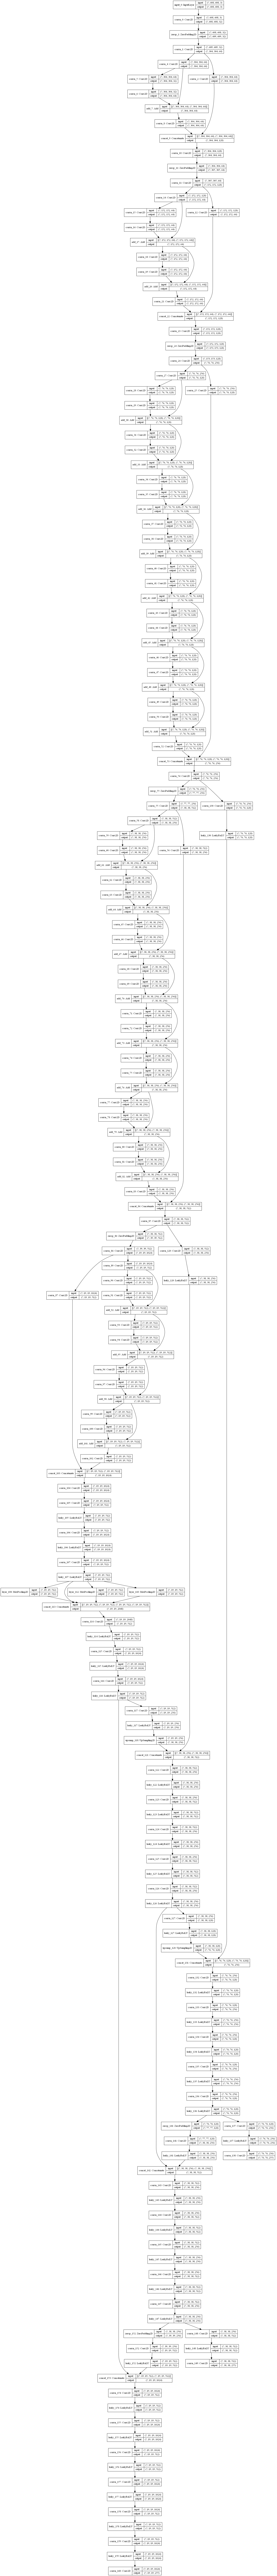

In [35]:
tf.keras.utils.plot_model(
    modeledh, show_shapes=True
)

In [253]:
from keras.models import Model
import struct

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                print("reading 64 bytes")
                w_f.read(8)
            else:
                print("reading 32 bytes")
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        count = 0
        ncount = 0
        for i in range(161):
            try:

                conv_layer = model.get_layer('convn_' + str(i))
                filter = conv_layer.kernel.shape[-1]
                nweights = np.prod(conv_layer.kernel.shape) # kernel*kernel*c*filter
                
                print("loading weights of convolution #" + str(i)+ "- nb parameters: "+str(nweights+filter))             
                
                if i  in [138, 149, 160]:
                    print("Special processing for layer "+ str(i))
                    bias  = self.read_bytes(filter) # bias
                    weights = self.read_bytes(nweights) # weights
                
                else:                    
                    bias  = self.read_bytes(filter) # bias
                    scale = self.read_bytes(filter) # scale
                    mean  = self.read_bytes(filter) # mean
                    var   = self.read_bytes(filter) # variance
                    weights = self.read_bytes(nweights) # weights
                    
                    bias = bias - scale  * mean / (np.sqrt(var + 0.00001)) #normalize bias

                    weights = np.reshape(weights,(filter,int(nweights/filter)))  #normalize weights
                    A = scale / (np.sqrt(var + 0.00001))
                    A= np.expand_dims(A,axis=0)
                    weights = weights* A.T
                    weights = np.reshape(weights,(nweights))
                

                weights = weights.reshape(list(reversed(conv_layer.get_weights()[0].shape)))                 
                weights = weights.transpose([2,3,1,0])
                
                if len(conv_layer.get_weights()) > 1:
                    a=conv_layer.set_weights([weights, bias])
                else:    
                    a=conv_layer.set_weights([weights])
                
                count = count+1
                ncount = ncount+nweights+filter
             
            except ValueError:
                print("no convolution #" + str(i)) 
        
        print(count, "Conv normalized layers loaded ", ncount, " parameters")
    
    def reset(self):
        self.offset = 0

In [254]:
# Get and compute the weights
weight_reader = WeightReader('models/yolo/yolov4.weights')
weight_reader.load_weights(modeledh)

reading 64 bytes
loading weights of convolution #0- nb parameters: 896
loading weights of convolution #1- nb parameters: 18496
loading weights of convolution #2- nb parameters: 4160
no convolution #3
loading weights of convolution #4- nb parameters: 4160
loading weights of convolution #5- nb parameters: 2080
loading weights of convolution #6- nb parameters: 18496
no convolution #7
loading weights of convolution #8- nb parameters: 4160
no convolution #9
loading weights of convolution #10- nb parameters: 8256
loading weights of convolution #11- nb parameters: 73856
loading weights of convolution #12- nb parameters: 8256
no convolution #13
loading weights of convolution #14- nb parameters: 8256
loading weights of convolution #15- nb parameters: 4160
loading weights of convolution #16- nb parameters: 36928
no convolution #17
loading weights of convolution #18- nb parameters: 4160
loading weights of convolution #19- nb parameters: 36928
no convolution #20
loading weights of convolution #21-

In [124]:
test_layer = modeledh.get_layer('convn_0')
w=test_layer.get_weights()[0] 
b=test_layer.get_weights()[1] 
print(w.shape)
print(b.shape)
print(b)


(3, 3, 3, 32)
(32,)
[  9.995235     1.4192724    0.8431928    3.880384     0.64011
   4.8541927    1.015842     0.8812368    2.6518679    1.6302294
   2.2304382    1.8126843    6.2966394    1.5123429   -8.274309
  -0.8738987   11.163226     1.3032792    1.2200907    1.8167338
   1.6193068    2.2508576    2.0915682    1.4894633   -0.58034337
   1.472437     2.434105     3.205092     1.6877954    3.0819223
   2.1175227  -22.535404  ]


In [255]:
# save the model to file
! rm models\yolo\yolov4.h5

modeledh.save('models/yolo/yolov4.h5')
! dir models\yolo\*.h5

 Le volume dans le lecteur C s'appelle Windows
 Le num‚ro de s‚rie du volume est CCDC-AB26

 R‚pertoire de C:\Users\edh\deep learning\models\yolo

09/06/2020  00:03        35ÿ474ÿ940 yolov3-tiny.h5
14/05/2020  21:44       248ÿ676ÿ368 yolov3.h5
19/06/2020  13:26       257ÿ813ÿ004 yolov4.h5
               3 fichier(s)      541ÿ964ÿ312 octets
               0 R‚p(s)  287ÿ029ÿ608ÿ448 octets libres


In [124]:
from keras.models import load_model, Model
yolo_model = load_model("models/yolo/yolov4.h5")

C:\Users\edh\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [125]:
yolo_model.summary()

Model: "Yolo_v4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
convn_0 (Conv2D)                (None, 608, 608, 32) 896         input_0[0][0]                    
__________________________________________________________________________________________________
zerop_1 (ZeroPadding2D)         (None, 609, 609, 32) 0           convn_0[0][0]                    
__________________________________________________________________________________________________
convn_1 (Conv2D)                (None, 304, 304, 64) 18496       zerop_1[0][0]                    
____________________________________________________________________________________________

concat_103 (Concatenate)        (None, 19, 19, 1024) 0           convn_102[0][0]                  
                                                                 convn_87[0][0]                   
__________________________________________________________________________________________________
convn_104 (Conv2D)              (None, 19, 19, 1024) 1049600     concat_103[0][0]                 
__________________________________________________________________________________________________
convn_105 (Conv2D)              (None, 19, 19, 512)  524800      convn_104[0][0]                  
__________________________________________________________________________________________________
leaky_105 (LeakyReLU)           (None, 19, 19, 512)  0           convn_105[0][0]                  
__________________________________________________________________________________________________
convn_106 (Conv2D)              (None, 19, 19, 1024) 4719616     leaky_105[0][0]                  
__________

Total params: 64,329,949
Trainable params: 64,329,949
Non-trainable params: 0
__________________________________________________________________________________________________


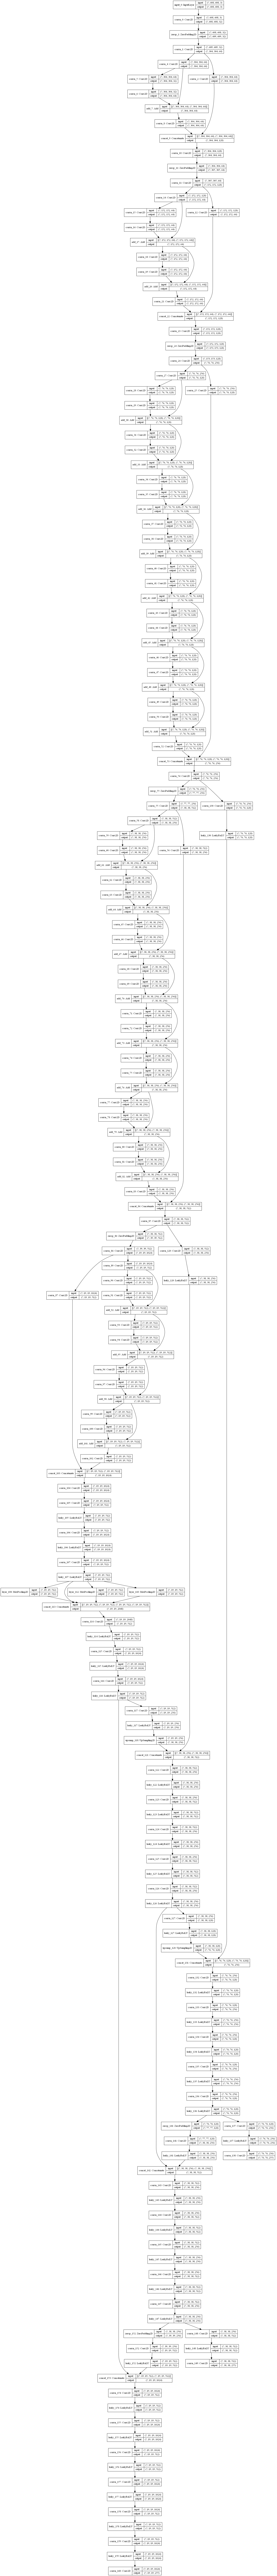

In [148]:
tf.keras.utils.plot_model(
    yolo_model, show_shapes=True
)

In [149]:

o=yolo_model.get_layer('convn_0')
print(o.get_config())



{'name': 'convn_0', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'mish', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


In [150]:
config_dict = yolo_model.get_config()
print(config_dict)

{'name': 'Yolo_v4', 'layers': [{'name': 'input_0', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 608, 608, 3), 'dtype': 'float32', 'sparse': False, 'name': 'input_0'}, 'inbound_nodes': []}, {'name': 'convn_0', 'class_name': 'Conv2D', 'config': {'name': 'convn_0', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'mish', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'inbound_nodes': [[['input_0', 0, 0, {}]]]}, {'name': 'zerop_1', 'class_name': 'ZeroPadding2D', 'config': {'name': 'zerop_1', 'trainable': True, 'dtype': 'float32',

In [126]:
def read_labels(labels_path):
    with open(labels_path) as f:
        labels = f.readlines()
    labels = [c.strip() for c in labels]
    return labels

In [127]:
labels = read_labels("models/yolo/coco_classes.txt")
print(labels)
print("Nb labels:", len(labels))

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
Nb labels: 80


In [128]:
NETWORK_W        = 608
NETWORK_H        = 608
NB_BOX           = 3
NB_CLASS         = len(labels)
OBJ_THRESHOLD    = 0.3
NMS_THRESHOLD    = 0.3
grids = [(76,76), (38,38), (19,19)]
anchors = [ [12, 16, 19, 36, 40, 28],[36, 75, 76, 55, 72, 146],[142, 110, 192, 243, 459, 401]]
scales_x_y = [1.2, 1.1, 1.05]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 2
TRUE_BOX_BUFFER  = 50

In [130]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3
     
        

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h
    
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union


class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
 
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
 
        return self.label
 
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score

In [131]:
import xml.etree.ElementTree as ET
import pickle
import os
from os import listdir, getcwd
from os.path import join

def convert(image_wh, box, grid_w, grid_h, Boxanchor, yolo_id):
    dw = image_wh[0]/ grid_w
    dh = image_wh[1]/ grid_h
    center_x = (box[0] + box[1])/2.0
    center_x = center_x / dw
    center_y = (box[2] + box[3])/2.0
    center_y = center_y / dh
    
    grid_x = int(np.floor(center_x))
    grid_y = int(np.floor(center_y))
    
    if grid_x < grid_w and grid_y < grid_h:
        w = (box[1] - box[0]) / dw
        h = (box[3] - box[2]) / dh
        
        # find the anchor that best predicts this box
        best_anchor = -1
        max_iou     = -1
    
        shifted_box = BoundBox(0,0,w,h)
    
        for i in range(len(anchors[yolo_id])//2):
            iou    = bbox_iou(shifted_box, Boxanchor[i])                   
            if max_iou < iou:
                best_anchor = i
                max_iou     = iou
    
        return (center_x,center_y,w,h,grid_x,grid_y,best_anchor)
    
    else: # not compatible with the grid size
        return (0,0,0,0,0,0,-1)
    

def convert_annotation(year, image_set, image_id, grid_w, grid_h, Boxanchor, yolo_id, VOC_path):
    in_file = open(VOC_path+'VOC%s\\Annotations\\%s.xml'%(year, image_id))
    out_file = open('VOCdevkit\\VOC%s_%s\\labels_%s\\%s.txt'%(year, image_set, yolo_id, image_id), 'w')
    tree=ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    image_w = int(size.find('width').text)
    image_h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in labels or int(difficult)==1:
            continue
        cls_id = labels.index(cls)
        
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert((image_w,image_h), b, grid_w, grid_h, Boxanchor, yolo_id)
        
        if bb[-1] != -1:
            out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')


def build_label_files (year, image_set, VOC_path):
    yolo_id = 0
    
    for grid_w, grid_h in grids:
        print("grid :",grid_w, grid_h)

        Boxanchor= [BoundBox(0, 0, anchors[yolo_id][2*i], anchors[yolo_id][2*i+1]) for i in range(int(len(anchors[yolo_id])//2))]
       
        if not os.path.exists('VOCdevkit\\VOC%s_%s\\labels_%s\\' %(year, image_set, yolo_id)):
            os.makedirs('VOCdevkit\\VOC%s_%s\\labels_%s\\' %(year, image_set, yolo_id))
        
        image_ids = open(VOC_path+'VOC%s\\ImageSets\\Main\\%s.txt'%(year, image_set)).read().strip().split()

        for image_id in image_ids:
            convert_annotation(year, image_set, image_id, grid_w, grid_h, Boxanchor, yolo_id, VOC_path)
            
        yolo_id+=1
    return

76 76
38 38
19 19
76 76
38 38
19 19


In [ ]:
build_label_files ('2012', 'train', '..\\yolo4\\train\\VOCdevkit\\')

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, interpolation = 'bilinear', target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    
    return image, width, height

In [132]:
def build_train (year, image_set, nb_train, VOC_path):
 
    train_x  = np.zeros ((nb_train, NETWORK_H, NETWORK_W, 3), dtype=np.float32)
    train_y0 = np.zeros ((nb_train, grids[0][1], grids[0][0], NB_BOX,(4+1+NB_CLASS)), dtype=np.float32)
    train_y1 = np.zeros ((nb_train, grids[1][1], grids[1][0], NB_BOX,(4+1+NB_CLASS)), dtype=np.float32)
    train_y2 = np.zeros ((nb_train, grids[2][1], grids[2][0], NB_BOX,(4+1+NB_CLASS)), dtype=np.float32)
    bc = 0 
        
    image_ids = open(VOC_path+'VOC%s\\ImageSets\\Main\\%s.txt'%(year, image_set)).read().strip().split()

    
    for image_id in image_ids:        
        # Pre-process the image train_x
        img_filename = VOC_path+'VOC%s\\JPEGImages\\%s.jpg'%(year, image_id)
        image, image_w, image_h = load_image_pixels(img_filename, (NETWORK_W, NETWORK_H))
        train_x[bc,:,:,:] = image
        
        # build true predict train_y0 and box b0
        labels_file = open('VOCdevkit\\VOC%s_%s\\labels_0\\%s.txt'%(year, image_set, image_id), 'r')
        
        rec = np.fromfile(labels_file, dtype=np.float32, sep = " ")
        for i in range(len(rec)//8):
            classid,x,y,w,h,grid_x,grid_y,best_anchor = rec[8*i:8*(i+1)]
            train_y0[bc, int(grid_y),int(grid_x),int(best_anchor), 0:4] = x,y,w,h
            train_y0[bc, int(grid_y),int(grid_x),int(best_anchor), 4] = 1.
            train_y0[bc, int(grid_y),int(grid_x),int(best_anchor), 5+ int(classid)] = 0.9 #Class label smoothing, use 0.9 instead of 1.0 in order to mitigate overfitting.
            
        # build true predict train_y1 and box b1
        labels_file = open('VOCdevkit\\VOC%s_%s\\labels_1\\%s.txt'%(year, image_set, image_id), 'r')
        
        rec = np.fromfile(labels_file, dtype=np.float32, sep = " ")
        true_box_index = 0
        for i in range(len(rec)//8):
            classid,x,y,w,h,grid_x,grid_y,best_anchor = rec[8*i:8*(i+1)]
            train_y1[bc, int(grid_y),int(grid_x),int(best_anchor), 0:4] = x,y,w,h
            train_y1[bc, int(grid_y),int(grid_x),int(best_anchor), 4] = 1.
            train_y1[bc, int(grid_y),int(grid_x),int(best_anchor), 5+ int(classid)] = 0.9 #Class label smoothing, use 0.9 instead of 1.0 in order to mitigate overfitting.

        # build true predict train_y2 and box b2
        labels_file = open('VOCdevkit\\VOC%s_%s\\labels_2\\%s.txt'%(year, image_set, image_id), 'r')
        
        rec = np.fromfile(labels_file, dtype=np.float32, sep = " ")
        true_box_index = 0
        for i in range(len(rec)//8):
            classid,x,y,w,h,grid_x,grid_y,best_anchor = rec[8*i:8*(i+1)]
            train_y2[bc, int(grid_y),int(grid_x),int(best_anchor), 0:4] = x,y,w,h
            train_y2[bc, int(grid_y),int(grid_x),int(best_anchor), 4] = 1.
            train_y2[bc, int(grid_y),int(grid_x),int(best_anchor), 5+ int(classid)] = 0.9 #Class label smoothing, use 0.9 instead of 1.0 in order to mitigate overfitting.
             
        bc+=1
        if bc == nb_train:
            break
            
    return(train_x,  [train_y0,train_y1,train_y2])    

In [135]:
train_x, train_y = build_train('2012', 'train', 2, '..\\yolo4\\train\\VOCdevkit\\')

..\yolo4\train\VOCdevkit\VOC2012\JPEGImages\2008_000002.jpg
..\yolo4\train\VOCdevkit\VOC2012\JPEGImages\2008_000003.jpg
(2, 608, 608, 3)
(2, 76, 76, 3, 85)
(2, 38, 38, 3, 85)
(2, 19, 19, 3, 85)
[[36.632    30.805334 62.928    57.152     1.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.9       0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.      ]
 

In [141]:
def custom_loss(y_true, y_pred):
   
    print("TensorFlow version: {}".format(tf.__version__))
    print("Eager execution: {}".format(tf.executing_eagerly()))
    print("Keras version: {}".format(tf.keras.__version__))
   
    print(y_pred.shape)
    grid_h, grid_w = y_pred.shape[1:3] 
    print ("grid_h, grid_w",grid_h, grid_w)
    
    if grid_h == 76:
        anchor = anchors[0]
    elif grid_h == 38: 
        anchor = anchors[1]
    else:    
        anchor = anchors[2]     
        
    mask_shape = tf.shape(y_true)[:4]
    print ("mask_shape",mask_shape)

    
    cell_x = tf.cast((tf.reshape(tf.tile(tf.range(grid_w), [grid_h]), (1, grid_h, grid_w, 1, 1))),dtype=tf.float32)
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))
    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, NB_BOX, 1])
    
    
    ######  prediction
    y_pred = tf.reshape(y_pred, (BATCH_SIZE, grid_h, grid_w, NB_BOX, NB_CLASS+5))

    ### adjust x and y  
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) # x, y)
    pred_box_xy = pred_box_xy + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(anchor, [1,1,1,NB_BOX,2])
    
    ### adjust objectness
    pred_box_obj = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = tf.sigmoid(y_pred[..., 5:])
    
    
    ######  true
    y_true = tf.reshape(y_true, (BATCH_SIZE, grid_h, grid_w, NB_BOX, NB_CLASS+5))
    print ("y_true", y_true.shape)

    ### adjust x and y  
    true_box_xy = y_true[..., :2] # x, y
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4]
    
    ### adjust objectness
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half

    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas + 1e-10
    iou_scores  = tf.truediv(intersect_areas, union_areas)
   
    true_box_obj = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)

    
    
    ######  coefficients   
   
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    ### is 1 when there is an object in the cell i, else 0.
    coord_mask = tf.zeros(mask_shape)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    print("sum coord_mask",tf.reduce_sum(coord_mask))
    
    ### objectness mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    for i in range(BATCH_SIZE):
        bd = y_true[i,:,:,:,:4]
        nozero = tf.not_equal(bd, tf.zeros((grid_h, grid_w, NB_BOX, 4)))
        bdd = tf.boolean_mask(bd, nozero)
        s=tf.squeeze(tf.size(bdd)//4)
        c= tf.zeros((50-s,4))
        bdd=tf.reshape(bdd, (s,4))
        bdd = tf.concat([bdd,c],axis=0)
        bdd = tf.expand_dims(bdd,0)
        bdd = tf.expand_dims(bdd,0)
        bdd = tf.expand_dims(bdd,0)
        bdd = tf.expand_dims(bdd,0)
        if (i==0):
            true_boxes =bdd
        else:
            true_boxes = tf.concat([true_boxes,bdd], axis=0)  
    
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    print("best_ious", tf.reduce_max(best_ious))
    
    obj_mask = tf.zeros(mask_shape)
    obj_mask = tf.cast((best_ious < 0.6),dtype=tf.float32) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    obj_mask = obj_mask + y_true[..., 4] * OBJECT_SCALE

    print("sum obj_mask",tf.reduce_sum(obj_mask))
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    ### is 1 when there is a particular class is predicted, else 0.
    class_mask = tf.zeros(mask_shape)
    class_weights = np.ones(NB_CLASS, dtype='float32')
    class_mask = y_true[..., 4] * tf.gather(class_weights, true_box_class) * CLASS_SCALE
    print("sum class_mask",tf.reduce_sum(class_mask))
    
    nb_coord_box = tf.reduce_sum(tf.cast((coord_mask > 0.0),dtype=tf.float32))
    nb_obj_box  = tf.reduce_sum(tf.cast((obj_mask  > 0.0),dtype=tf.float32))
    nb_class_box = tf.reduce_sum(tf.cast((class_mask > 0.0),dtype=tf.float32))
    print("nb_coord_box",nb_coord_box)
    print("nb_obj_box",nb_obj_box)
    print("nb_class_box",nb_class_box) 
      
    ### loss
    loss_xy    = tf.reduce_sum(coord_mask * tf.square(true_box_xy - pred_box_xy)) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(coord_mask * tf.square(tf.sqrt(tf.abs(true_box_wh)) - tf.sqrt(tf.abs(pred_box_wh)))) / (nb_coord_box + 1e-6) / 2.
    loss_obj   = tf.reduce_sum(obj_mask * tf.square(true_box_obj-pred_box_obj)) / (nb_obj_box + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(class_mask * loss_class) / (nb_class_box + 1e-6)

    print("loss_xy",loss_xy.shape)
    print("sum loss_xy",tf.reduce_sum(loss_xy))
    
    print("loss_wh",loss_wh.shape)
    print("sum loss_wh",tf.reduce_sum(loss_wh))
    
    print("loss_obj",loss_obj.shape)
    print("sum loss_obj",tf.reduce_sum(loss_obj))
        
    print("loss_class",loss_class.shape)
    print("sum loss_class",tf.reduce_sum(loss_class))
    
    loss = loss_xy + loss_wh + loss_obj + loss_class
    print("loss",loss.shape)
    print()
    return loss


In [137]:
#test custom loss
BATCH_SIZE = 1
print("y_true",train_y[0].shape)
print(train_y[0][:,30,36,2])
print("y_pred",yhat[0].shape)
loss = custom_loss(train_y[0], yhat[0])
print("loss",loss.shape)
print("max loss",tf.reduce_max(loss))
print("min loss",tf.reduce_min(loss))
print("mean loss",tf.reduce_mean(loss))

y_true (2, 76, 76, 3, 85)
[[36.632    30.805334 62.928    57.152     1.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.9       0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.  

InvalidArgumentError: Input to reshape is a tensor with 2945760 values, but the requested shape has 1472880 [Op:Reshape]

In [142]:
#optimizer = tf.keras.optimizers.Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
optimizer = tf.keras.optimizers.SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD.RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

In [143]:
yolo_model.compile(loss=custom_loss, optimizer=optimizer)

TensorFlow version: 2.1.0
Eager execution: False
Keras version: 2.2.4-tf
(None, 76, 76, 255)
grid_h, grid_w 76 76
mask_shape Tensor("loss_2/convn_138_loss/custom_loss/strided_slice:0", shape=(4,), dtype=int32)
y_true (1, 76, 76, 3, 85)
sum coord_mask Tensor("loss_2/convn_138_loss/custom_loss/Sum:0", shape=(), dtype=float32)
best_ious Tensor("loss_2/convn_138_loss/custom_loss/Max_1:0", shape=(), dtype=float32)
sum obj_mask Tensor("loss_2/convn_138_loss/custom_loss/Sum_1:0", shape=(), dtype=float32)
sum class_mask Tensor("loss_2/convn_138_loss/custom_loss/Sum_2:0", shape=(), dtype=float32)
nb_coord_box Tensor("loss_2/convn_138_loss/custom_loss/Sum_3:0", shape=(), dtype=float32)
nb_obj_box Tensor("loss_2/convn_138_loss/custom_loss/Sum_4:0", shape=(), dtype=float32)
nb_class_box Tensor("loss_2/convn_138_loss/custom_loss/Sum_5:0", shape=(), dtype=float32)
loss_xy ()
sum loss_xy Tensor("loss_2/convn_138_loss/custom_loss/Sum_10:0", shape=(), dtype=float32)
loss_wh ()
sum loss_wh Tensor("loss_

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        print("Starting train")

    def on_train_end(self, logs=None):
        print("Stop train")
        
    def on_epoch_begin(self, epoch, logs=None):
        print("--Start epoch {}".format(epoch))

    def on_epoch_end(self, epoch, logs=None):
        print("--End epoch {}, the average training loss is {:7.2f}, testing loss is {:7.2f}".format(epoch, logs["loss"], logs["val_loss"]))        
        
    def on_train_batch_begin(self, batch, logs=None):
        print("---Start training batch {}, size {}".format(batch,logs["size"]))
        
    def on_train_batch_end(self, batch, logs=None):
        print("---End training batch {}, total loss is {:7.2f}, loss (76*76) is {:7.2f}, loss (38*38) is {:7.2f}, loss (19*19) is {:7.2f}"
              .format(batch, logs["loss"],logs["convn_138_loss"],logs["convn_149_loss"],logs["convn_160_loss"]))      

    def on_test_begin(self, logs=None):
        print("-Start testing")
        
    def on_test_end(self, logs=None):
        print("-Stop testing")
    
    def on_test_batch_begin(self, batch, logs=None):
        print("---Start testing batch {}, size {}".format(batch,logs["size"]))
        
    def on_test_batch_end(self, batch, logs=None):
        print("---End testing batch {}, total loss is {:7.2f}, loss (76*76) is {:7.2f}, loss (38*38) is {:7.2f}, loss (19*19) is {:7.2f}"
              .format(batch, logs["loss"],logs["convn_138_loss"],logs["convn_149_loss"],logs["convn_160_loss"]))  

In [140]:
# Fit the model including validation data
import datetime
start = datetime.datetime.now()

EScallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history = yolo_model.fit(x=train_x, y=train_y, validation_data = (val_x,val_y), epochs= 1,batch_size =BATCH_SIZE, verbose=2, callbacks=[CustomCallback(),EScallback ])

elapsed = datetime.datetime.now()-start
print("elapsed seconds: ",elapsed.seconds)

Epoch 1/1
2/2 [==============================] - ETA: 1:31 - loss: 139.3667 - convn_138_loss: 9.8728 - convn_149_loss: 25.4551 - convn_160_loss: 104.038 - 139s 69s/step - loss: 83.4554 - convn_138_loss: 11.4574 - convn_149_loss: 15.7077 - convn_160_loss: 56.2903


In [ ]:
# plot learning curves
from matplotlib import pyplot
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [20]:
# Pre-process the image
photo_filename = '..\\yolo4\\train\\VOCdevkit\\VOC2012\\JPEGImages\\2008_000002.jpg'
image, image_w, image_h = load_image_pixels(photo_filename, (NETWORK_W, NETWORK_H))
print("image initial size: ", image_w, image_h)
print("input image",image.shape)

image initial size:  500 375
input image (1, 608, 608, 3)


In [323]:
input_w, input_h = 608, 608
image = np.fromfile("imgfile", dtype=np.float32).reshape(3,input_w, input_h) 
image = np.transpose(image, (1,2,0))
# add a dimension so that we have one sample
image = np.expand_dims(image, axis=0)
print("image avg",tf.math.reduce_mean(image))
print("image min",tf.math.reduce_min(image))
print("image max",tf.math.reduce_max(image))
print("image std",tf.math.reduce_std(image))
print("image sum",tf.math.reduce_sum(image)) 
print (image.shape)
print(image[0,0,0:10,0])

image avg tf.Tensor(0.3956518, shape=(), dtype=float32)
image min tf.Tensor(0.0, shape=(), dtype=float32)
image max tf.Tensor(1.0, shape=(), dtype=float32)
image std tf.Tensor(0.2811408, shape=(), dtype=float32)
image sum tf.Tensor(438774.66, shape=(), dtype=float32)
(1, 608, 608, 3)
[0.0627451  0.05888168 0.05501825 0.05115483 0.04729141 0.04342798
 0.03956456 0.03570114 0.03183771 0.03477082]


In [21]:
# Run the model
yhat = yolo_model.predict(image)

print("output",[a.shape for a in yhat])

output [(1, 76, 76, 255), (1, 38, 38, 255), (1, 19, 19, 255)]


In [37]:
#test_input = np.ones((1, 608, 608, 3), dtype=float)
test0_input = np.zeros((608, 608, 1), dtype=float)
test1_input = np.eye(608, 608, dtype=float)
test1_input = np.expand_dims(test1_input,axis=2)
test_input = np.concatenate((test1_input,test0_input,test0_input),axis=2)
test_input = np.expand_dims(test_input,axis=0)
print (test_input.shape)
print (test_input[0:,:,:,0])
print()
print (test_input[0:,:,:,1])
print()
print (test_input[0:,:,:,2])
print()
print("test_input avg",tf.math.reduce_mean(test_input))
print("test_input min",tf.math.reduce_min(test_input))
print("test_input max",tf.math.reduce_max(test_input))
print("test_input std",tf.math.reduce_std(test_input))
print("test_input sum",tf.math.reduce_sum(test_input))
# make prediction
yhat = yolo_model.predict(test_input)


(1, 608, 608, 3)
[[[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 1.]]]

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]

test_input avg tf.Tensor(0.0005482456140350877, shape=(), dtype=float64)
test_input min tf.Tensor(0.0, shape=(), dtype=float64)
test_input max tf.Tensor(1.0, shape=(), dtype=float64)
test_input std tf.Tensor(0.02340822592128194, shape=(), dtype=float64)
test_input sum tf.Tensor(608.0, shape=(), dtype=float64)


In [51]:
print(image.shape)
print("image avg",tf.math.reduce_mean(image[0,:,:,0]))
print("image min",tf.math.reduce_min (image[0,:,:,0]))
print("image max",tf.math.reduce_max (image[0,:,:,0]))
print("image std",tf.math.reduce_std (image[0,:,:,0]))
print("image 0 sum",tf.math.reduce_sum (image[0,0,:,0]))
print("image 1 sum",tf.math.reduce_sum (image[0,0,:,1]))
print("image 2 sum",tf.math.reduce_sum (image[0,0,:,2]))
print()
print(yhat[0][0].shape)
print(yhat[3][0].shape)
print(yhat[4][0].shape)
print(yhat[5][0].shape)
print(yhat[6][0].shape)
print()
y138= yhat[0][0]
print("y138 avg",tf.math.reduce_mean(y138))
print("y138 min",tf.math.reduce_min(y138))
print("y138 max",tf.math.reduce_max(y138))
print("y138 std",tf.math.reduce_std(y138))
print("y138 sum",tf.math.reduce_sum(y138))
print()
y149= yhat[1][0]
print("y149 avg",tf.math.reduce_mean(y149))
print("y149 min",tf.math.reduce_min(y149))
print("y149 max",tf.math.reduce_max(y149))
print("y149 std",tf.math.reduce_std(y149))
print("y149 sum",tf.math.reduce_sum(y149))
print()
y160= yhat[2][0]
print("y160 avg",tf.math.reduce_mean(y160))
print("y160 min",tf.math.reduce_min(y160))
print("y160 max",tf.math.reduce_max(y160))
print("y160 std",tf.math.reduce_std(y160))
print("y160 sum",tf.math.reduce_sum(y160))
print()
y107= yhat[3][0]
print("y107 avg",tf.math.reduce_mean(y107))
print("y107 min",tf.math.reduce_min(y107))
print("y107 max",tf.math.reduce_max(y107))
print("y107 std",tf.math.reduce_std(y107))
print("y107 sum",tf.math.reduce_sum(y107))
y108= yhat[4][0]
print()
print("y108 avg",tf.math.reduce_mean(y108))
print("y108 min",tf.math.reduce_min(y108))
print("y108 max",tf.math.reduce_max(y108))
print("y108 std",tf.math.reduce_std(y108))
print("y108 sum",tf.math.reduce_sum(y108))
y110= yhat[5][0]
print()
print("y110 avg",tf.math.reduce_mean(y110))
print("y110 min",tf.math.reduce_min(y110))
print("y110 max",tf.math.reduce_max(y110))
print("y110 std",tf.math.reduce_std(y110))
print("y110 sum",tf.math.reduce_sum(y110))
y112= yhat[6][0]
print()
print("y112 avg",tf.math.reduce_mean(y112))
print("y112 min",tf.math.reduce_min(y112))
print("y112 max",tf.math.reduce_max(y112))
print("y112 std",tf.math.reduce_std(y112))
print("y112 sum",tf.math.reduce_sum(y112))

(1, 608, 608, 3)
image avg tf.Tensor(0.3691583, shape=(), dtype=float32)
image min tf.Tensor(0.0, shape=(), dtype=float32)
image max tf.Tensor(1.0, shape=(), dtype=float32)
image std tf.Tensor(0.29469198, shape=(), dtype=float32)
image 0 sum tf.Tensor(77.74872, shape=(), dtype=float32)
image 1 sum tf.Tensor(139.93967, shape=(), dtype=float32)
image 2 sum tf.Tensor(93.795944, shape=(), dtype=float32)

(76, 76, 255)
(19, 19, 512)
(19, 19, 512)
(19, 19, 512)
(19, 19, 512)

y138 avg tf.Tensor(-6.0056734, shape=(), dtype=float32)
y138 min tf.Tensor(-18.7933, shape=(), dtype=float32)
y138 max tf.Tensor(2.3965359, shape=(), dtype=float32)
y138 std tf.Tensor(2.2950242, shape=(), dtype=float32)
y138 sum tf.Tensor(-8845636.0, shape=(), dtype=float32)

y149 avg tf.Tensor(-6.850911, shape=(), dtype=float32)
y149 min tf.Tensor(-22.414314, shape=(), dtype=float32)
y149 max tf.Tensor(6.157441, shape=(), dtype=float32)
y149 std tf.Tensor(2.933762, shape=(), dtype=float32)
y149 sum tf.Tensor(-2522642.5

In [199]:
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w, anchors_nb, scales_x_y):
    grid_h, grid_w = netout.shape[:2]  
    nb_box = anchors_nb
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5 # 5 = bx,by,bh,bw,pc

    print("grid_h,grid_w: ",grid_h,grid_w)  
    print("nb class: ",nb_class)   
    
    boxes = []
    netout[..., :2] = _sigmoid(netout[..., :2]) # x, y
    netout[..., :2] = netout[..., :2]*scales_x_y - 0.5*(scales_x_y - 1.0) # scale x, y

    netout[..., 4:] = _sigmoid(netout[..., 4:]) # objectness + classes probabilities

    for i in range(grid_h*grid_w):

        row = i / grid_w
        col = i % grid_w
        
        
        for b in range(nb_box):
            # 4th element is objectness
            objectness = netout[int(row)][int(col)][b][4]

            if(objectness > obj_thresh):
                print("objectness: ",objectness)                
            
                # first 4 elements are x, y, w, and h
                x, y, w, h = netout[int(row)][int(col)][b][:4]
                x = (col + x) / grid_w # center position, unit: image width
                y = (row + y) / grid_h # center position, unit: image height
                w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
                h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height            
                print(" x, y, w, h : ", x, y, w, h )
                # last elements are class probabilities
                classes = objectness*netout[int(row)][col][b][5:]
                
                classes *= classes > obj_thresh
                box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)           
                boxes.append(box)
    return boxes


In [200]:
# Compute the Yolo layers
obj_thresh = 0.25
anchors = [ [12, 16, 19, 36, 40, 28],[36, 75, 76, 55, 72, 146],[142, 110, 192, 243, 459, 401]]
scales_x_y = [1.2, 1.1, 1.05]
boxes = list()

for i in range(len(anchors)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], obj_thresh, input_h, input_w, len(anchors), scales_x_y[i])

print("nb boxes detected; ",len(boxes))

grid_h,grid_w:  76 76
nb class:  80
grid_h,grid_w:  38 38
nb class:  80
grid_h,grid_w:  19 19
nb class:  80
objectness:  0.4993665
 x, y, w, h :  0.44750108530646876 0.48489388650143905 0.892143997902933 1.0658725139341856
objectness:  0.37546057
 x, y, w, h :  0.4900587326601932 0.48942971956036424 1.0010839622271688 1.0396629877780612
objectness:  0.71904147
 x, y, w, h :  0.40187431322900874 0.5184456394815049 0.8222453786354316 1.0437358284467144
objectness:  0.93077695
 x, y, w, h :  0.44556077844218206 0.520071095376794 0.9016842059791088 1.074127402940863
objectness:  0.9331552
 x, y, w, h :  0.4919895827770233 0.5229739368457212 0.9800641501420423 1.0656344427874214
objectness:  0.2575821
 x, y, w, h :  0.4434679166266793 0.5612624254583322 0.9539559210993742 1.0814653091916913
objectness:  0.30955118
 x, y, w, h :  0.4910792410373688 0.5647195524786317 1.0474871822485798 1.0764980506347983
nb boxes detected;  7


In [190]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
 new_w, new_h = net_w, net_h
 for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [191]:
# Correct the boxes according the inital size of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

In [192]:
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [193]:
# Suppress the non Maximal boxes
do_nms(boxes, 0.5)
print("nb boxes remaining: ",len(boxes))

nb boxes remaining:  7


In [194]:
import colorsys
import random

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] ), int(x[1] ), int(x[2] )), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh, colors):
    v_boxes, v_labels, v_scores, v_colors = list(), list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):

            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                v_colors.append(colors[i])
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores, v_colors

In [195]:
# Get the details of the detected objects for a threshold > 0.6
class_threshold = 0.25
colors = generate_colors(labels)
v_boxes, v_labels, v_scores, v_colors = get_boxes(boxes, labels, class_threshold, colors)
print("nb boxes remaining: ",len(v_boxes))

nb boxes remaining:  1


In [196]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores, v_colors):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color=v_colors[i])
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()

dog 91.36373996734619 -2 432 -8 528


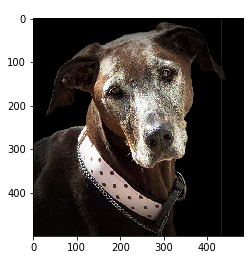

In [37]:
# Draw the result
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i],  v_boxes[i].xmin, v_boxes[i].xmax, v_boxes[i].ymin, v_boxes[i].ymax)
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores, v_colors)